# 用卷积神经网络做图片分类器

## 从 0 开始训练分类器

此处使用的训练集是 Kaggle 上的 [Dogs vs. Cats](https://www.kaggle.com/c/dogs-vs-cats/data) 比赛的数据集，这个数据集中包含了 2.5w 训练数据，其中猫狗图片各 1.25w，测试集包含 1.25w 张图片。

这里只使用 2000 张图片作为训练集，1000 张图片作为验证集，1000 张作为测试集。

In [1]:
import os
import matplotlib.pyplot as plt
import warnings

%matplotlib inline
warnings.filterwarnings('ignore')

### 准备数据

先从原始数据中，把需要的数据放到特定的目录中，具体来说就是要让 keras 的数据接口能够读取。

图片存放方式如下：

```
- cat/
    - xx.jpg
    - xx.jpg
    - ..
- dog/
    - xx.jpg
    - xx.jpg
    - ..
```

文件夹的名字是便签，文件夹中的文件就是属于该便签的样本。

因为需要训练集、验证集、测试集三个数据集，因此需要创建三个目录，比如 `train`，`val`，`test`，里面按上面所说的格式放置数据。然后使用 keras 的 `ImageDataGenerator` 类的 `flow_from_directory` 方法，就可以完成样本的读入了。

下面这段脚本从原始数据集的 train 目录读取数据，并构造后面实验所需的数据集。

In [2]:
import os, shutil

origin_data_dir = './cat_dog/train'
base_dir = './datasets'

for dir1 in ['train', 'val', 'test']:
    os.mkdir(os.path.join(base_dir, dir1))
    for dir2 in ['cat', 'dog']:
        os.mkdir(os.path.join(base_dir, dir1, dir2))
    
for label in ['cat', 'dog']:
    fnames = ['{}.{}.jpg'.format(label, i) for i in range(2000)]
    for i, fname in enumerate(fnames):
        src = os.path.join(origin_data_dir, fname)
        
        if i < 1000:
            d = 'train'
        elif i < 1500:
            d = 'val'
        else:
            d = 'test'

        dst = os.path.join(base_dir, d, label, fname)
        
        shutil.copyfile(src, dst)

In [7]:
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

from keras.preprocessing.image import ImageDataGenerator

train_data_gen = ImageDataGenerator(rescale=1./255)
val_data_gen = ImageDataGenerator(rescale=1./255)
test_data_gen = ImageDataGenerator(rescale=1./255)

train_generator = train_data_gen.flow_from_directory(
        train_dir,
        target_size=(150, 150),
        batch_size=2000,
        class_mode='binary')

validation_generator = val_data_gen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=1000,
        class_mode='binary')

test_generator = test_data_gen.flow_from_directory(
        test_dir,
        target_size=(150, 150),
        batch_size=100,
        class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1001 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


使用 GPU 训练的时候，如果使用 `model.fit_generator` 会发现 GPU 利用率很低，尤其是使用较小的 `batch_size` 的时候，因为在训练过程中需要周期性地去读文件，这样 GPU 就空闲着了。所以这里一次性把所有数据读到内存中，然后使用 GPU 训练的时候会快不少。

In [8]:
train_x, train_y = train_generator.next()
val_x, val_y = validation_generator.next()

train_x.shape, train_y.shape

((2000, 150, 150, 3), (2000,))

### 构建模型

In [2]:
from keras import models, layers, optimizers

model = models.Sequential()

model.add(layers.Conv2D(32, (3, 3), activation='relu',input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])

Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.


### 训练模型

这一步需要使用 GPU 了，CPU 跑起来就显得很慢了。

In [12]:
history = model.fit(
    train_x, train_y,
    epochs=20, verbose=0,
    validation_data=(val_x, val_y))

如果单个图片较大，而内存又较小，或者因为其他原因必须使用 `model.fit_generator`，就需要像下面这样写：

```python
train_generator = train_data_gen.flow_from_directory(
        train_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

validation_generator = val_data_gen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=10,
        class_mode='binary')

history = model.fit_generator(
    train_generator,
    steps_per_epoch=100,
    epochs=20,
    validation_data=validation_generator,
    validation_steps=50)
```

因为训练数据有 2000 条，而 generator 的 batch_size 为 20，因此生成器生成 100 次数据就能用完所有样本，这里的 steps_pre_epoch 就是指在一个 epoch 中，需要从生成器取多少次数据。因为这里的生成器是无穷无尽地生成数据（circle），所以必须得告知生成多少次（多少个 step）算一个 epoch。

In [6]:
model.save('cats_and_dogs_small.h5')

### 观察过拟合情况

观察验证集上的 loss 和 acc 随着 epoch 的变化情况，可以确定在多少个 epoch 后模型过拟合了。

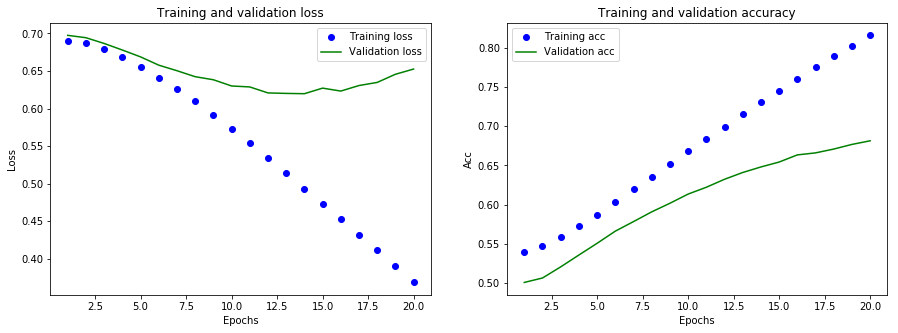

In [7]:
def smooth_curve(points, factor=0.9):
    if len(points) == 0:
        return []
    smoothed_points = [points[0]]
    for point in points[1:]:
        pre = smoothed_points[-1]
        smoothed_points.append(pre * factor + point * (1 - factor))
    return smoothed_points

def plot_history(history):
    acc = smooth_curve(history.history['acc'])
    val_acc = smooth_curve(history.history['val_acc'])
    loss = smooth_curve(history.history['loss'])
    val_loss = smooth_curve(history.history['val_loss'])
    
    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(15,5))

    plt.subplot(121)
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'g-', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(122)
    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'g-', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Acc')
    plt.legend()

plot_history(model.history)

如果观察验证集上的 loss 可以看出大概在 15 个 epoch 后，模型都开始 overfitting 了。

但这里在 20 个 epoch 过程中训练集和验证集上的精度都在上升，但是在第 15 个 epoch 之后，验证集上的 loss 就开始上升了。直觉上，loss 上升，会伴随着 acc 的下降。但实验证明并不是这样。

对模型对多训练一些 epoch 会是怎样了。对模型重新初始化后，训练 50 个 epoch，得到了下面的曲线。

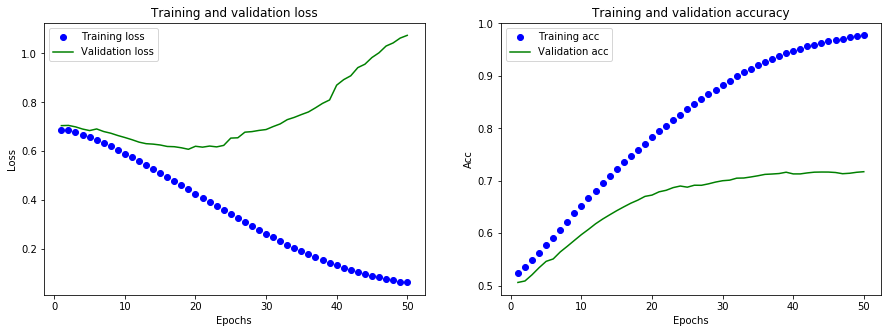

In [11]:
plot_history(model.history)

这次在 20 个 epoch 时验证集上 loss 就开始上升，但是直到 50 个 epoch 结束，验证集上的精度都未见下降。

其原因我想是这样的：在二分类任务中，只要 sigmoid 的输出大于 0，则分类为 1，否则分类为 0。对一个类别为 1 的样本，sigmoid 函数输出结果，比如，为 -1。那么它就会被错分。这会影响到精度。继续训练下去，sigmoid 函数对该样本输出为 -10，也就是说错的更多了。这个时候 loss 会变大，但精度 (acc) 不会受影响，因为之前分错了，现在可以说分的更错了，但都是错（sigmoid 输出小于 0），所以模型精度是一样的。

随着训练的深入，过拟合也越来越严重，验证集上错分的样本越错越多，所以 loss 越来越大。验证集上分类正确的样本，可能就是和训练集中样本相似的哪一部分样本，这部分样本不会因为过拟合而被分错。

至于为什么验证集上 loss 上升的同时，精度也在上升，我猜有可能是这样：过拟合导致之前分错的越错越多（sigmoid 输出越来越接近 -∞），即 loss 越来越大。而 acc 上升只会是暂时的，即在训练集存在相似样本的哪部分验证集样本，会随着模型在训练集上过拟合而被正确分类。

## data augmentation

augmentation 的意思是扩大、增多、增强，data augmentation 是 cv 中常采用的一种策略，将训练数据做移动、旋转、缩放等操作，从训练数据中产生更多样本，以此来扩大训练集规模。通过变换的图像，人眼看上去虽然和原图表现的内容差不多，但对于 CNN 而言，确实不同的。使用这些经过变换的图像，可以让模型具有更好的泛化能力，同时因为增长了训练集数据，也可以更好地对抗过拟合。

在 keras 中提供了 ImageDataGenerator 这个类，用它可以轻松地配置图像变换的细节。

In [9]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

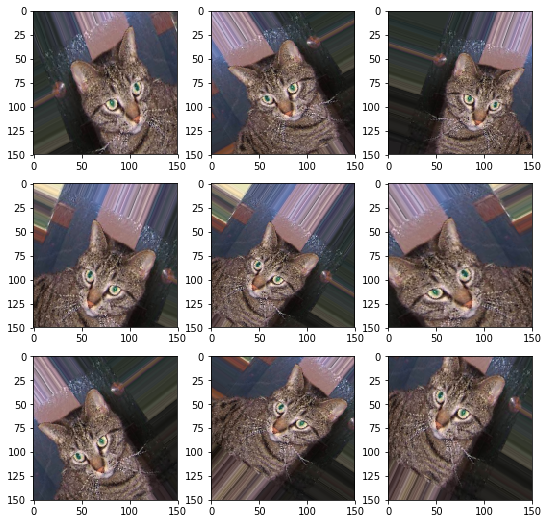

In [13]:
from keras.preprocessing import image

fnames = [os.path.join(train_dir, 'cat', fname) for fname in os.listdir(os.path.join(train_dir, 'cat'))]
img_path = fnames[3]

img = image.load_img(img_path, target_size=(150, 150))

x = image.img_to_array(img)
x = x.reshape((1,) + x.shape)

plt.figure(figsize=(9,9))
i = 1
for batch in datagen.flow(x, batch_size=1):
    plt.subplot(3,3,i)
    imgplot = plt.imshow(image.array_to_img(batch[0]))
    i += 1
    if i % 10 == 0:
        break

## 使用预训练模型

卷积神经网络的架构通常都是先使用多个卷积层加池化层，最后加上几个全连接层。前面的卷积层和池化层可以理解为用来抽取特制的，而后面的全连接层是使用这些特征来完成具体的任务。

因此，可以使用一些在超大规模数据集上训练好的卷积网络模型中的卷积层来抽取特征，然后使用这些特征来做具体的分类任务。预训练卷积模型就相当于一个数据的 transformer，它只是把原始数据做了变换。

一种策略使用，使用预训练模型抽取特征，然后单独训练一个全连接的神经网络，来做具体的分类任务。另一种策略是在预训练的卷积模型之上加上全连接层，然后 end-to-end 地进行训练。

这里使用 VGG16 预训练模型，下面这一步需要下载模型，大约 50M。

In [40]:
from keras.applications import VGG16

conv_base = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

In [3]:
conv_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

**数据生成器**

In [37]:
from keras.preprocessing.image import ImageDataGenerator

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

train_data_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,)

val_data_gen = ImageDataGenerator(rescale=1./255)
test_data_gen = ImageDataGenerator(rescale=1./255)

train_generator = train_data_gen.flow_from_directory(
        train_dir,
        target_size=(150, 150),
        batch_size=100,
        class_mode='binary')

validation_generator = val_data_gen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=100,
        class_mode='binary')

test_generator = test_data_gen.flow_from_directory(
        test_dir,
        target_size=(150, 150),
        batch_size=100,
        class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1001 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


### 利用预训练模型做特征抽取

**抽取特征**

In [42]:
import numpy as np

batch_size = 100

def extract_features(generator, sample_count):
    features = np.zeros(shape=(sample_count, 4, 4, 512))
    labels = np.zeros(shape=(sample_count))
    
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            # Note that since generators yield data indefinitely in a loop,
            # we must `break` after every image has been seen once.
            break
    return features, labels

In [43]:
train_features, train_labels = extract_features(train_generator, 4000)
validation_features, validation_labels = extract_features(validation_generator, 1000)
test_features, test_labels = extract_features(test_generator, 1000)

train_features = np.reshape(train_features, (4000, 4 * 4 * 512))
validation_features = np.reshape(validation_features, (1000, 4 * 4 * 512))
test_features = np.reshape(test_features, (1000, 4 * 4 * 512))

**训练全连接层**

In [46]:
from keras import models
from keras import layers
from keras import optimizers

model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_dim=4 * 4 * 512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer=optimizers.RMSprop(lr=2e-5),loss='binary_crossentropy',metrics=['acc'])

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [47]:
history = model.fit(train_features, train_labels, epochs=50,
    batch_size=64,
    validation_data=(validation_features, validation_labels))

Train on 4000 samples, validate on 1000 samples
Epoch 1/50
4000/4000 [==============================] - 2s 478us/step - loss: 0.6696 - acc: 0.5943 - val_loss: 0.4948 - val_acc: 0.8060
Epoch 2/50
4000/4000 [==============================] - 0s 107us/step - loss: 0.5395 - acc: 0.7298 - val_loss: 0.4133 - val_acc: 0.8500
Epoch 3/50
4000/4000 [==============================] - 0s 104us/step - loss: 0.4766 - acc: 0.7672 - val_loss: 0.3671 - val_acc: 0.8650
Epoch 4/50
4000/4000 [==============================] - 0s 104us/step - loss: 0.4394 - acc: 0.7973 - val_loss: 0.3432 - val_acc: 0.8620
Epoch 5/50
4000/4000 [==============================] - 0s 108us/step - loss: 0.4129 - acc: 0.8177 - val_loss: 0.3241 - val_acc: 0.8730
Epoch 6/50
4000/4000 [==============================] - 0s 110us/step - loss: 0.3856 - acc: 0.8350 - val_loss: 0.3035 - val_acc: 0.8860
Epoch 7/50
4000/4000 [==============================] - 0s 110us/step - loss: 0.3638 - acc: 0.8415 - val_loss: 0.2941 - val_acc: 0.8860


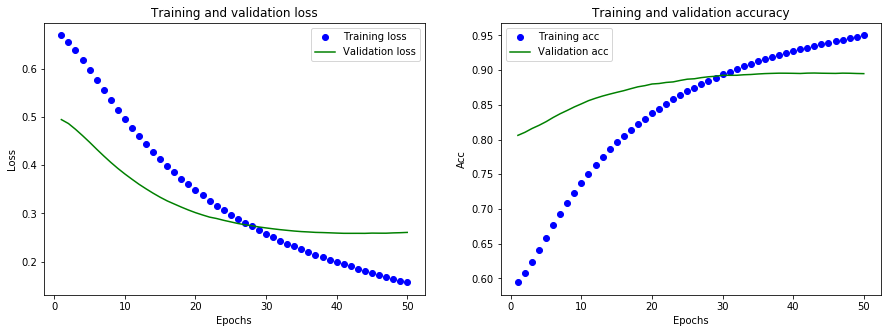

In [48]:
plot_history(model.history)

In [49]:
model.evaluate(test_features, test_labels)

1000/1000 [==============================] - 0s 103us/step


[0.26665733386576174, 0.895]

经过 50 个 epoch，并没有发生很严重的 overfitting。在测试集上得到了 90% 的准确度。

### 端到端地使用预训练模型

把预训练模型加入到整个模型中，得到一个端到端的训练流程，这和前面的效果其实是一样的。只是因为预训练模型的参数级多，而且这些参数可能已经训练的很好了，我们并不想去改变它们。可以设置 `trainable` 为 `False` 来锁定预训练模型的参数。

In [50]:
from keras import models
from keras import layers

conv_base.trainable = False

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=2e-5),
              metrics=['acc'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_2 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 2,097,665
Non-trainable params: 14,714,688
_________________________________________________________________


In [51]:
history = model.fit_generator(
        train_generator,
        steps_per_epoch=20,
        epochs=30,
        validation_data=validation_generator,
        validation_steps=10)

Epoch 1/30
20/20 [==============================] - 17s 830ms/step - loss: 0.6687 - acc: 0.5940 - val_loss: 0.5655 - val_acc: 0.7370
Epoch 2/30
20/20 [==============================] - 14s 693ms/step - loss: 0.5701 - acc: 0.7385 - val_loss: 0.4929 - val_acc: 0.8102
Epoch 3/30
20/20 [==============================] - 14s 718ms/step - loss: 0.5256 - acc: 0.7525 - val_loss: 0.4280 - val_acc: 0.8380
Epoch 4/30
20/20 [==============================] - 14s 709ms/step - loss: 0.4841 - acc: 0.7925 - val_loss: 0.4032 - val_acc: 0.8491
Epoch 5/30
20/20 [==============================] - 14s 722ms/step - loss: 0.4616 - acc: 0.7960 - val_loss: 0.3743 - val_acc: 0.8613
Epoch 6/30
20/20 [==============================] - 14s 702ms/step - loss: 0.4301 - acc: 0.8210 - val_loss: 0.3422 - val_acc: 0.8657
Epoch 7/30
20/20 [==============================] - 14s 720ms/step - loss: 0.4176 - acc: 0.8190 - val_loss: 0.3486 - val_acc: 0.8568
Epoch 8/30
20/20 [==============================] - 14s 710ms/step - 

In [52]:
model.save('cats_and_dogs_vgg.h5')

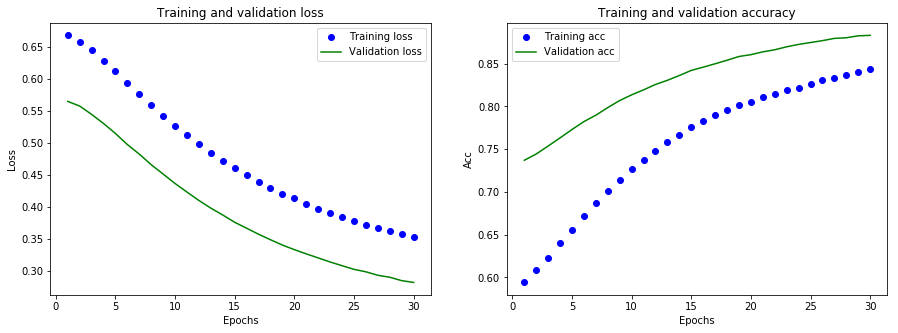

In [53]:
plot_history(model.history)

In [54]:
model.evaluate_generator(test_generator, steps=10)

[0.26189730018377305, 0.8940000057220459]

看样子 30 个 epoch 还有点不够，但尽管如此，依然在测试集上得到和前面步骤差不多的结果。

### 对预训练模型进行微调 (fine-tuning)

这里预训练的卷积模型 VGG16 是在 ImageNet 任务上训练的，在此处用来做猫狗分类看起来也挺恰当。另外，我们知道卷积网络中，越靠前的卷积层抽取的特征越通用，比如是一些各个角度的线。而靠后的卷积层，抽取的特征就比较抽象了，和具体的任务有很大关系。因此，这里采用的预训练模型的最后几个卷积层对当前任务而言，可能并不是最佳的。

如果能使用当前训练数据，对预训练模型的最后的几个卷积层进行些许训练，整个卷积网络能够更好地抽取适合当前任务的特征。

这里让 VGG16 的最后 3 个卷积层可以训练，这可以通过设置 `layer.trainable` 为 `True` 来轻松完成。

In [10]:
conv_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

In [5]:
conv_base.trainable = True

trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        trainable = True
    
    layer.trainable = trainable

In [9]:
from keras import models, layers, optimizers

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=2e-5),
              metrics=['acc'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_2 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 9,177,089
Non-trainable params: 7,635,264
_________________________________________________________________


In [11]:
history = model.fit_generator(
        train_generator,
        steps_per_epoch=20,
        epochs=30,
        validation_data=validation_generator,
        validation_steps=10)

Instructions for updating:
Use tf.cast instead.
Epoch 1/30
20/20 [==============================] - 17s 826ms/step - loss: 0.6340 - acc: 0.6325 - val_loss: 0.4066 - val_acc: 0.8480
Epoch 2/30
20/20 [==============================] - 15s 740ms/step - loss: 0.4585 - acc: 0.7870 - val_loss: 0.2991 - val_acc: 0.8557
Epoch 3/30
20/20 [==============================] - 14s 714ms/step - loss: 0.3892 - acc: 0.8255 - val_loss: 0.2586 - val_acc: 0.8879
Epoch 4/30
20/20 [==============================] - 15s 743ms/step - loss: 0.3480 - acc: 0.8525 - val_loss: 0.2627 - val_acc: 0.8812
Epoch 5/30
20/20 [==============================] - 14s 716ms/step - loss: 0.3248 - acc: 0.8545 - val_loss: 0.1855 - val_acc: 0.9267
Epoch 6/30
20/20 [==============================] - 15s 737ms/step - loss: 0.2877 - acc: 0.8755 - val_loss: 0.2197 - val_acc: 0.8957
Epoch 7/30
20/20 [==============================] - 15s 728ms/step - loss: 0.3014 - acc: 0.8635 - val_loss: 0.2054 - val_acc: 0.9112
Epoch 8/30
20/20 [===

In [12]:
model.evaluate_generator(test_generator, steps=10)

[0.15727824419736863, 0.9419999957084656]

经过了 fine-tuning 之后，测试集上的准确率又上升了 4 个百分点。